# LLM Aps Evaluation: RAGAS

RAGAS is an evaluation Framework for LLM Apps like RAGs or agents.   
It is open source and can integrate with several frameworks, both for datasets and LLMs

The main use is to run a evaluation job over a dataset, both with tradicional metrics and LLM-based evaluation
Other usages include:
* Testing data generation (synthetic)

link: [Ragas](https://docs.ragas.io/en/stable/)

# Metrics

RAGAS has a set of pre-implemented metrics, both tradicional and llm-based

![Metrics](https://docs.ragas.io/en/stable/_static/imgs/metrics_mindmap.png)


## Tradicional metrics

![rouge-img1](docs/rouge-img1.png)


**ROUGE:**  
Recall-Oriented Understudy for Gisting Evaluation  
Used for text summarization  
Compute the number of n-grams matching between a Reference (True) and a generation (Predicted)  

![rouge-calc](docs/rouge-calc.png)


**BLEU:**  
Bilingual Evaluation Understudy
Used for text translation  
Average the precision across a range of n-gram sizes  

![bleu-calc](docs/bleu-calc.png)

Source: [Generative AI with Large Language Models. Coursera](https://www.coursera.org/learn/generative-ai-with-llms/paidmedia?utm_medium=sem&utm_source=gg&utm_campaign=b2c_namer_generative-ai-with-llms_deeplearning-ai_ftcof_learn_px_dr_bau_gg_sem_pr-bd_us-ca_en_m_hyb_23-09_x&campaignid=20534248984&adgroupid=155736976280&device=c&keyword=generative%20ai%20with%20large%20language%20models%20certification&matchtype=b&network=g&devicemodel=&creativeid=673252278896&assetgroupid=&targetid=kwd-2259390252637&extensionid=&placement=&gad_source=1&gad_campaignid=20534248984&gbraid=0AAAAADdKX6ZnVEFBPECoYVPZTL9iwWfti&gclid=Cj0KCQjw5onGBhDeARIsAFK6QJYoCEgasLSEGmKD5aWLaAJK3l05AcCSclvrxIUlaKL16FbXmjXmy_4aAuFEEALw_wcB)

## LLM-Based Evaluation

Compare References and Generations by other LLM instructed to score given a precise task description and evaluation rubric

![eval-pyramid](docs/eval-pyramid.png)

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
from pathlib import Path
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

import pandas as pd
from ragas import evaluate, EvaluationDataset

from src import conf, utils
from rag import main as rag_builder

c:\Users\manuelalberto.romero\Documents\repos\dslabs\dslab-rag-e2e\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Params

In [5]:
conf_infra = conf.load(file="infra.yaml")
conf_settings = conf.load(file="settings.yaml")

LLM_EVAL = conf_settings.llm_workhorse  #!!!!
EMBEDDINGS = conf_settings.embeddings
INDEX_NAME = conf_settings.vdb_index
RETRIEVE_K = conf_settings.retrieve_k
LANGFUSE_HOST = conf_infra.llmops_url
VDB_URL = conf_infra.vdb_url


# Environment Variables

In [6]:
load_dotenv()

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

# Clients

In [7]:
from openai import OpenAI

client_openai = OpenAI(
    api_key=OPENAI_API_KEY
)

llm = ChatOpenAI(
    model=LLM_EVAL,
    api_key=OPENAI_API_KEY
    
    )

# Metrics

## Traditional: BLEU

In [8]:
from ragas import SingleTurnSample
from ragas.metrics import BleuScore

test_data = {
    "user_input": "summarise given text\nThe company reported an 8% rise in Q3 2024, driven by strong performance in the Asian market. Sales in this region have significantly contributed to the overall growth. Analysts attribute this success to strategic marketing and product localization. The positive trend in the Asian market is expected to continue into the next quarter.",
    "response": "The company experienced an 8% increase in Q3 2024, largely due to effective marketing strategies and product adaptation, with expectations of continued growth in the coming quarter.",
    "reference": "The company reported an 8% growth in Q3 2024, primarily driven by strong sales in the Asian market, attributed to strategic marketing and localized products, with continued growth anticipated in the next quarter."
}

metric = BleuScore()  # requires sacrebleu
test_data = SingleTurnSample(**test_data)
metric.single_turn_score(test_data)  # scorer

C:\Users\manuelalberto.romero\AppData\Local\Temp\ipykernel_45352\3988613919.py:2: DeprecationWarning: Importing BleuScore from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import BleuScore
  from ragas.metrics import BleuScore


0.13718598426177148

In [9]:
test_data = SingleTurnSample(
    user_input="Where is the Eiffel Tower located?",
    response="The Eiffel Tower is located in Paris.",
    reference="The Eiffel Tower is in Paris.", 
)


metric = BleuScore()  # requires sacrebleu
metric.single_turn_score(test_data)

0.5000000000000001

## LLM Based

### Response Relevancy and Answer Accuracy

**Response Relevancy: Q vs A**
1. Generate 3 artificial Qs based on the response (Q*s)
2. cosine similarity between user_input and Q*s
3. Average

> higher is better

**Answer Accuracy (NVIDIA): A vs GT**
1. score 0 (KO), 2, 4(OK)
2. template1: generated > reference 
3. template2: reference > generated 
4. Average and scale 0..1

> higher is better


Relenvant means correct?
> Es la venenosa la cicuta?
* Si
* La cicuta contiene un alcalide llamado coniína y en concentrciones suficientemente altas es tóxica para el ser humano

In [10]:
from ragas.llms import LangchainLLMWrapper
from langchain_openai import OpenAIEmbeddings

evaluator_llm = LangchainLLMWrapper(llm)
embeddings = OpenAIEmbeddings(
    model=EMBEDDINGS,
)


sample = SingleTurnSample(
    user_input="Where is the Eiffel Tower located?",
    response="The Eiffel Tower is located in Paris.",
    reference="The Eiffel Tower is located in Paris.",
    retrieved_contexts=["Paris is the capital of France."], 
)






C:\Users\manuelalberto.romero\AppData\Local\Temp\ipykernel_45352\538818594.py:4: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  evaluator_llm = LangchainLLMWrapper(llm)


In [11]:
from ragas.metrics import ResponseRelevancy


scorer = ResponseRelevancy(llm=evaluator_llm, embeddings=embeddings)
await scorer.single_turn_ascore(sample)

C:\Users\manuelalberto.romero\AppData\Local\Temp\ipykernel_45352\962452399.py:1: DeprecationWarning: Importing ResponseRelevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import ResponseRelevancy
  from ragas.metrics import ResponseRelevancy


np.float64(0.9999999999999994)

In [12]:
from ragas.metrics import AnswerAccuracy


scorer = AnswerAccuracy(llm=evaluator_llm)
await scorer.single_turn_ascore(sample)

C:\Users\manuelalberto.romero\AppData\Local\Temp\ipykernel_45352\1003457201.py:1: DeprecationWarning: Importing AnswerAccuracy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import AnswerAccuracy
  from ragas.metrics import AnswerAccuracy


1.0

## Context Recall: C vs GT

Context Recall measures how many of the relevant documents (or pieces of information) were successfully retrieved

1. split reference into claims
2. compare claims with retrieved_context
3. count claims backed up by the retrieved_context vs total claims

> higher is better

There is a `NonLLMContextRecall ` conterpart that compares `retrieved_contexts` vs `reference_contexts`

In [13]:
from ragas.metrics import LLMContextRecall


sample = SingleTurnSample(
    user_input="Where is the Eiffel Tower located?",
    response="The Eiffel Tower is located in Paris.",
    reference="The Eiffel Tower is located in Paris.",
    retrieved_contexts=["Paris is the capital of France.", "the Eiffel Tower construction started in 1887 in Paris"], 
)

context_recall = LLMContextRecall(llm=evaluator_llm)
await context_recall.single_turn_ascore(sample)

C:\Users\manuelalberto.romero\AppData\Local\Temp\ipykernel_45352\1386870115.py:1: DeprecationWarning: Importing LLMContextRecall from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import LLMContextRecall
  from ragas.metrics import LLMContextRecall


1.0

# Dataset Evaluation

In [14]:
df_eval = pd.read_csv(utils.path_data_raw / "dataset_qa.csv")

df_eval.head()

,Pregunta,Respuesta,Extracción literal,Sección/Subsección,Origen,Complejidad
0,¿A qué distancia de la Tierra está el sistema ...,"42,7 años luz","…a tan solo **42,7 años luz de la Tierra**…",1.3 Descubrimiento revolucionario…,párrafo,simple
1,¿Cuántas estrellas tiene el sistema Althéra?,Dos,…está compuesto por **dos estrellas principale...,2.2 Disposición y dinámica…,párrafo,simple
2,¿Cuál es el tipo espectral de Althéra A?,F7V,…Althéra A… una enana amarilla-blanca de tipo ...,3.1 Clasificación espectral…,párrafo,simple
3,¿Cuál es el tipo espectral de Althéra B?,K2V,…Althéra B… una enana naranja de tipo K2V…,3.1 Clasificación espectral…,párrafo,simple
4,¿Cuál es el periodo orbital mutuo de las dos e...,83 días,…en un periodo de **83 días**…,2.2 Disposición y dinámica…,párrafo,simple


C:\Users\manuelalberto.romero\AppData\Local\Temp\ipykernel_45352\408556172.py:1: RuntimeWarning: coroutine 'VectorStore.asimilarity_search' was never awaited
  rag_graph = rag_builder(


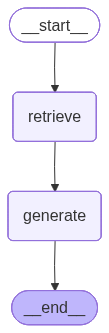

In [15]:
rag_graph = rag_builder(
            index_name=INDEX_NAME,
        retrieve_k=RETRIEVE_K,
)
rag_graph

In [16]:
df_sample = df_eval.sample(5)

questions = [{"question": x} for x in df_sample["Pregunta"].tolist()]

print("Questions:")
print(questions)

print("-"*30)
responses = rag_graph.batch(questions)  # responses: State
print(f"{len(responses)=}")
print(f"{responses[1]=}")

Questions:
[{'question': '¿Cuál es el periodo orbital mutuo de las dos estrellas de Althera?'}, {'question': '¿Qué planeta podría ser un planeta núcleo?'}, {'question': '¿Qué mecanismos podrían mantener agua líquida en Calther?'}, {'question': '¿Qué posibles orígenes tiene la inclinación axial de Krion V?'}, {'question': '¿Qué luna tiene órbita retrógrada e inestable?'}]
------------------------------
len(responses)=5
responses[1]={'question': '¿Qué planeta podría ser un planeta núcleo?', 'context': [Document(metadata={'Header 1': '4. Estructura general del sistema planetario', '_id': 'a9fdb21e-8d6a-42d0-9132-1fecbc8ebd0f', '_collection_name': 'space'}, page_content='## 4.2 Tipología de planetas  \n- Rocosos interiores: Thyros I y Névalis II presentan composiciones basadas en silicatos y metales, con escasa o nula actividad atmosférica en el primero y atmósfera densa de CO₂ en el segundo.\n- Planeta habitable: Aurelia III , en la zona habitable circumbinaria, combina océanos líquidos y

In [ ]:
retrieved_contexts = [[x.page_content for x in docs['context']] for docs in responses]
answer = [x['answer'] for x in responses]

df_sample_wans = df_sample.assign(
    response=answer,
    retrieved_contexts=retrieved_contexts
).rename(columns={
        "Pregunta": "user_input",
        "Respuesta": "reference",
    }
)[["user_input", "response", "reference", "retrieved_contexts"]]


df_sample_wans
# each row: SingleTurnSample
# sample = SingleTurnSample(
#     user_input="",
#     response="",
#     reference="",
#     retrieved_contexts=["", ""], 
# )



,user_input,response,reference,retrieved_contexts
23,¿Qué procesos podrían explicar el desequilibri...,"Según el contexto proporcionado, el desequilib...","Procesos abióticos complejos, incluida fotólis...",[## Adéndum: Debate científico sobre la habita...
1,¿Cuántas estrellas tiene el sistema Althéra?,El sistema Althéra está compuesto por dos estr...,Dos,[## Althéra está compuesto por dos estrellas p...
4,¿Cuál es el periodo orbital mutuo de las dos e...,El periodo orbital mutuo de las dos estrellas ...,83 días,[## Althéra está compuesto por dos estrellas p...
15,¿Qué luna tiene órbita retrógrada e inestable?,La luna que tiene órbita retrógrada e inestabl...,Calther,[## Luna destacada: \n- Calther: Satélite cap...
9,¿Qué cinturón de asteroides se encuentra entre...,El cinturón de asteroides que se encuentra jus...,Cinturón de Arges,[## 4.3 Cinturones de asteroides y discos de e...


In [ ]:
ds_ragas = EvaluationDataset.from_pandas(
    df_sample_wans
)

metrics = [
    AnswerAccuracy(llm=evaluator_llm), 
    LLMContextRecall(llm=evaluator_llm), 

]
results = evaluate(dataset=ds_ragas, metrics=metrics)

results

Evaluating: 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


{'nv_accuracy': 0.9000, 'context_recall': 1.0000}

In [ ]:
results.to_pandas()

,user_input,retrieved_contexts,response,reference,nv_accuracy,context_recall
0,¿Qué procesos podrían explicar el desequilibri...,[## Adéndum: Debate científico sobre la habita...,"Según el contexto proporcionado, el desequilib...","Procesos abióticos complejos, incluida fotólis...",1.0,1.0
1,¿Cuántas estrellas tiene el sistema Althéra?,[## Althéra está compuesto por dos estrellas p...,El sistema Althéra está compuesto por dos estr...,Dos,1.0,1.0
2,¿Cuál es el periodo orbital mutuo de las dos e...,[## Althéra está compuesto por dos estrellas p...,El periodo orbital mutuo de las dos estrellas ...,83 días,1.0,1.0
3,¿Qué luna tiene órbita retrógrada e inestable?,[## Luna destacada: \n- Calther: Satélite cap...,La luna que tiene órbita retrógrada e inestabl...,Calther,0.5,1.0
4,¿Qué cinturón de asteroides se encuentra entre...,[## 4.3 Cinturones de asteroides y discos de e...,El cinturón de asteroides que se encuentra jus...,Cinturón de Arges,1.0,1.0


In [ ]:
df_results = results.to_pandas()

df_results.to_csv(utils.path_data_processed / "dataset_eval_k3.csv")

**Exercise:**

1. Add tracing
2. Investigate how to generate synthetic Qs